In [40]:
# Data processing and manipulation
import os
import sys
import random
import numpy as np
import pandas as pd

# Machine learning and metrics
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (f1_score, accuracy_score, precision_score, recall_score, roc_auc_score, 
                             average_precision_score, confusion_matrix, precision_recall_curve, 
                             fbeta_score)

# PyTorch components
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [41]:
# Load Custom Functions
sys.path.append('./model')
from custom_functions import load_raw_data, extract_icd_codes, extract_dynamic_data_dict, extract_demographic_features, summarize_dynamic_features

In [42]:
# Set Seed for all packages
def set_seed(seed=42):
    """Set seeds to make the experiment more reproducible."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(49)

In [43]:
def plot_confusion_matrix(cm, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap=cmap)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()

# Load Data

In [44]:
# Define the percentage to load
percentage = '1%'  # Change this to '5%', '10%', etc., as needed

# Path to save tensors
tensor_save_path = f'./data/tensors/{percentage}_subset'

# Load tensors
dynamic_train_tensor = torch.load(os.path.join(tensor_save_path, 'dynamic_train_tensor.pt'))
static_train_tensor = torch.load(os.path.join(tensor_save_path, 'static_train_tensor.pt'))
label_tensor_train = torch.load(os.path.join(tensor_save_path, 'label_train_tensor.pt'))
train_tensor_repeated_static_features = torch.load(os.path.join(tensor_save_path, 'train_tensor_repeated_static_features.pt'))

dynamic_test_tensor = torch.load(os.path.join(tensor_save_path, 'dynamic_test_tensor.pt'))
static_test_tensor = torch.load(os.path.join(tensor_save_path, 'static_test_tensor.pt'))
label_tensor_test = torch.load(os.path.join(tensor_save_path, 'label_test_tensor.pt'))
test_tensor_repeated_static_features = torch.load(os.path.join(tensor_save_path, 'test_tensor_repeated_static_features.pt'))

dynamic_val_tensor = torch.load(os.path.join(tensor_save_path, 'dynamic_val_tensor.pt'))
static_val_tensor = torch.load(os.path.join(tensor_save_path, 'static_val_tensor.pt'))
label_tensor_val = torch.load(os.path.join(tensor_save_path, 'label_val_tensor.pt'))
val_tensor_repeated_static_features = torch.load(os.path.join(tensor_save_path, 'val_tensor_repeated_static_features.pt'))

In [45]:
# Create TensorDatasets and DataLoaders
train_dataset = TensorDataset(dynamic_train_tensor, static_train_tensor, label_tensor_train)
test_dataset = TensorDataset(dynamic_test_tensor, static_test_tensor, label_tensor_test)
val_dataset = TensorDataset(dynamic_val_tensor, static_val_tensor, label_tensor_val)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Implementing the Hybrid LSTM Model

In [46]:
# Check the actual number of features in the static data tensors
#print("Expected num_static_features:", num_static_features)
print("Actual static features in train:", static_train_tensor.shape[1])
print("Actual static features in val:", static_val_tensor.shape[1])
print("Actual static features in test:", static_test_tensor.shape[1])


Actual static features in train: 1486
Actual static features in val: 1486
Actual static features in test: 1486


In [47]:
class HybridLSTM(nn.Module):
    def __init__(self, num_dynamic_features, num_static_features, hidden_dim, output_dim):
        super(HybridLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=num_dynamic_features, hidden_size=hidden_dim, batch_first=True)
        self.static_dense = nn.Linear(num_static_features, hidden_dim)
        self.final_dense = nn.Linear(2 * hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, dynamic_input, static_input):
        # Dynamic pathway
        dynamic_output, (hidden, _) = self.lstm(dynamic_input)
        # Take the last hidden state
        dynamic_output = dynamic_output[:, -1, :]

        # Static pathway
        static_output = self.static_dense(static_input)

        # Combine outputs
        combined_output = torch.cat((dynamic_output, static_output), dim=1)
        final_output = self.final_dense(combined_output)
        return self.sigmoid(final_output)

# Model instantiation
num_dynamic_features = dynamic_train_tensor.shape[2]
num_static_features = static_train_tensor.shape[1]  
hidden_dim = 64
output_dim = 1  # Binary classification

model = HybridLSTM(num_dynamic_features, num_static_features, hidden_dim, output_dim)

# Data preparation (using your preprocessed tensors)
train_dataset = TensorDataset(dynamic_train_tensor, static_train_tensor, label_tensor_train)
val_dataset = TensorDataset(dynamic_val_tensor, static_val_tensor, label_tensor_val)
test_dataset = TensorDataset(dynamic_test_tensor, static_test_tensor, label_tensor_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Forward pass
for dynamic_data, static_data, labels in train_loader:
    outputs = model(dynamic_data, static_data)
    print(outputs.shape)  # Output shape check
    break

torch.Size([16, 1])


In [48]:
# Assuming 'model' is an instance of HybridLSTM
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.BCELoss()
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5, verbose=True)

num_epochs = 100
best_val_loss = float('inf')
early_stopping_patience = 10
epochs_no_improve = 0

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for dynamic_input, static_input, labels in train_loader:
        optimizer.zero_grad()

        outputs = model(dynamic_input, static_input).squeeze()
        outputs = outputs.view(-1)  # Ensure output and labels have the same shape
        labels = labels.view(-1)

        loss = criterion(outputs, labels)
        loss.backward()

        # Implement gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        total_loss += loss.item()

    val_loss = 0
    with torch.no_grad():
        for dynamic_input, static_input, labels in val_loader:
            outputs = model(dynamic_input, static_input).squeeze()
            outputs = outputs.view(-1)  # Flatten the output for consistency
            labels = labels.view(-1)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    scheduler.step(val_loss)  # Adjust learning rate based on validation loss

    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {total_loss / len(train_loader)}, Validation Loss: {val_loss / len(val_loader)}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), './saved_models/Hybrid_LSTM/state_dict/best_hybrid_lstm_model.pth')  # Save the best model
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve == early_stopping_patience:
            print("Early stopping initiated.")
            break

# Optionally, load the best model for further use or evaluation
model.load_state_dict(torch.load('./saved_models/Hybrid_LSTM/state_dict/best_hybrid_lstm_model.pth'))
model.eval()


Epoch 1/100, Training Loss: 0.4210826903581619, Validation Loss: 0.30444792211055755
Epoch 2/100, Training Loss: 0.22402601192394891, Validation Loss: 0.2855829581618309
Epoch 3/100, Training Loss: 0.18894144839474133, Validation Loss: 0.2795951724052429
Epoch 4/100, Training Loss: 0.13064431824854442, Validation Loss: 0.24796746671199799
Epoch 5/100, Training Loss: 0.08742591162167844, Validation Loss: 0.2351682037115097
Epoch 6/100, Training Loss: 0.05231369827829656, Validation Loss: 0.2385803282260895
Epoch 7/100, Training Loss: 0.02856482718405979, Validation Loss: 0.24145342856645585
Epoch 8/100, Training Loss: 0.015772479497605844, Validation Loss: 0.23781427145004272
Epoch 00009: reducing learning rate of group 0 to 5.0000e-04.
Epoch 9/100, Training Loss: 0.010186099292089542, Validation Loss: 0.24697076082229613
Epoch 10/100, Training Loss: 0.007532932529492038, Validation Loss: 0.24879610538482666
Epoch 11/100, Training Loss: 0.006516582238310505, Validation Loss: 0.252103945

HybridLSTM(
  (lstm): LSTM(835, 64, batch_first=True)
  (static_dense): Linear(in_features=1486, out_features=64, bias=True)
  (final_dense): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [49]:
# Load the best model
model.load_state_dict(torch.load('./saved_models/Hybrid_LSTM/state_dict/best_hybrid_lstm_model.pth'))

# Make predictions
model.eval()
with torch.no_grad():
    test_outputs = model(dynamic_test_tensor, static_test_tensor).squeeze()
    test_loss = criterion(test_outputs, label_tensor_test)
    test_predictions = (test_outputs > 0.5).int()

print(f"Test Loss: {test_loss.item()}")
print(f"Test Accuracy: {(test_predictions == label_tensor_test.int()).float().mean().item()}")

Test Loss: 0.17177575826644897
Test Accuracy: 0.9154929518699646


In [50]:
# Define the directory path
directory_path = f'./saved_models/Hybrid_LSTM/trained_on_{percentage}'

# Ensure the directory exists
os.makedirs(directory_path, exist_ok=True)

# Save model and optimizer state
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, os.path.join(directory_path, 'best_hybrid_LSTM_model.pth'))

In [51]:
def evaluate_hybrid_lstm_model(model, dynamic_test_tensor, static_test_tensor, label_tensor_test, directory, model_name, beta=2):
    model.eval()  # Set the model to evaluation mode
    sns.set()  # For better plot styling

    with torch.no_grad():
        # Predict on the test set
        test_outputs = model(dynamic_test_tensor, static_test_tensor).squeeze()
        test_probs = test_outputs.numpy()  # Probability predictions

    # True labels for comparison
    true_labels = label_tensor_test.numpy()

    # Calculate precision-recall curve and corresponding thresholds
    precision, recall, thresholds = precision_recall_curve(true_labels, test_probs)

    # Calculate F-beta scores for each possible threshold
    f_beta_scores = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)
    f_beta_scores = np.nan_to_num(f_beta_scores)  # Handling NaNs

    # Find the threshold that maximizes the F-beta score
    optimal_idx = np.argmax(f_beta_scores)
    best_threshold = thresholds[optimal_idx]

    # Use the best threshold found
    test_predictions = (test_probs > best_threshold).astype(int)

    # Calculate metrics
    accuracy = accuracy_score(true_labels, test_predictions)
    precision = precision_score(true_labels, test_predictions, zero_division=0)
    recall = recall_score(true_labels, test_predictions)
    f1 = f1_score(true_labels, test_predictions)
    auc_roc = roc_auc_score(true_labels, test_probs)
    auprc = average_precision_score(true_labels, test_probs)

    # Print the results
    print(f"Best Threshold: {best_threshold:.2f}")
    print(f"{model_name} Model Performance on Test Set:")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(f"AUC-ROC: {auc_roc:.2f}")
    print(f"AUPRC: {auprc:.2f}")

    # Ensure the directory exists
    if not os.path.exists(directory):
        os.makedirs(directory)

    # Save the confusion matrix
    cm = confusion_matrix(true_labels, test_predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(f'{directory}/{model_name}_confusion_matrix.png')
    plt.close()  # Close the plot to avoid display

    # Save performance metrics to a text file
    metrics_filepath = f'{directory}/{model_name}_metrics.txt'
    with open(metrics_filepath, 'w') as f:
        f.write(f"{model_name} Model Performance on Test Set:\n")
        f.write(f"Best Threshold: {best_threshold:.2f}\n")
        f.write(f"Accuracy: {accuracy:.2f}\n")
        f.write(f"Precision: {precision:.2f}\n")
        f.write(f"Recall: {recall:.2f}\n")
        f.write(f"F1 Score: {f1:.2f}\n")
        f.write(f"AUC-ROC: {auc_roc:.2f}\n")
        f.write(f"AUPRC: {auprc:.2f}\n")

    print(f"Performance metrics saved to: {metrics_filepath}")

# Example usage
evaluate_hybrid_lstm_model(model, dynamic_test_tensor, static_test_tensor, label_tensor_test, f'./saved_models/Hybrid_LSTM/trained_on_{percentage}/', 'Hybrid_LSTM')

Best Threshold: 0.14
Hybrid_LSTM Model Performance on Test Set:
Accuracy: 0.89
Precision: 0.42
Recall: 0.83
F1 Score: 0.56
AUC-ROC: 0.96
AUPRC: 0.58
Performance metrics saved to: ./saved_models/Hybrid_LSTM/trained_on_1%//Hybrid_LSTM_metrics.txt


C:\Users\soere\AppData\Local\Temp\ipykernel_33124\2004008501.py:17: RuntimeWarning: invalid value encountered in divide
  f_beta_scores = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)


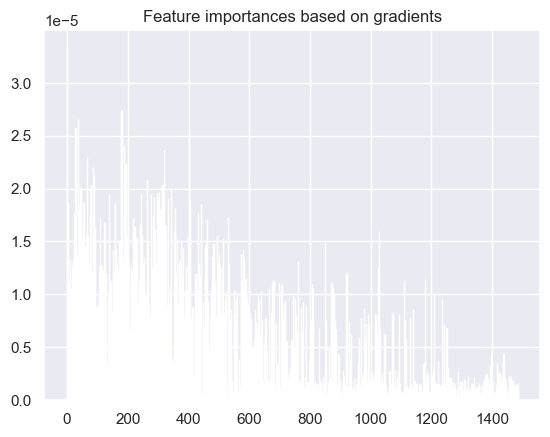

In [52]:
# Assuming 'model' and 'static_train_tensor' are defined and loaded as per your setup
model.eval()
static_train_tensor.requires_grad = True

# Forward pass
outputs = model(dynamic_train_tensor, static_train_tensor).mean()  # mean() to get a scalar for grad

# Compute gradients
outputs.backward()

# Feature importances based on gradients
feature_importances = static_train_tensor.grad.abs().mean(dim=0)

# Visualize the importances
plt.bar(range(len(feature_importances)), feature_importances.detach().numpy())
plt.title('Feature importances based on gradients')
plt.show()
